In [3]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import skew
import math

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from utils.dataManagers.dataSteward import DataSteward
from utils.dataManagers.informations import informer
from utils.predictions import *
from utils.dataManagers.dataWrangler import *

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from utils.ClassifierResults import TreeResults

ds = DataSteward('mapper_and_most_frequent', 'mean')
column_desc = informer.get_column_descriptions()

train = ds.train_data
test = ds.test_data
ytrain = ds.train_response

In [2]:
number_type = get_number_types(train)

skewness = number_type.apply(lambda x: skew(x))
cols_to_log = skewness[np.abs(skewness.sort_values()) >= .75].index

train_log = log_given_columns(train, cols_to_log)
test_log = log_given_columns(test, cols_to_log)
trainWithDummies, testWithDummies = get_df_for_predictions(train_log, test_log)

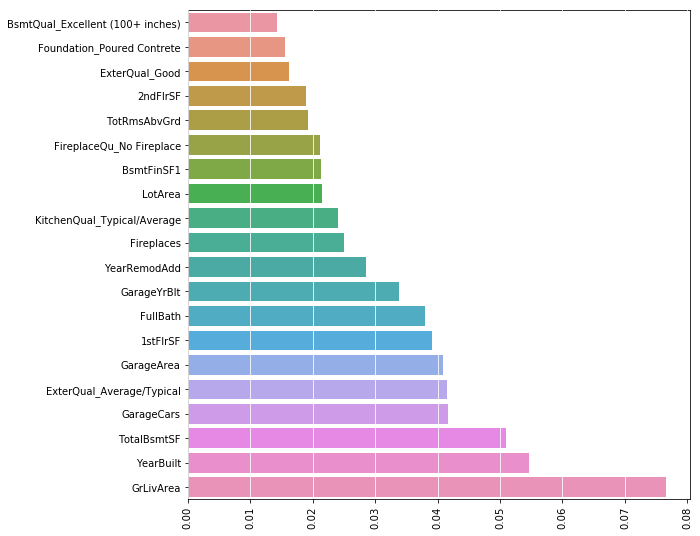

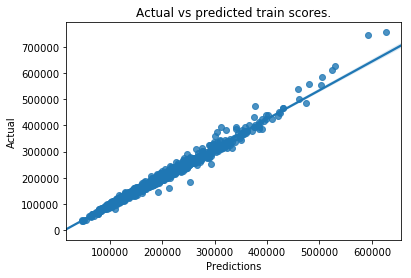

c:\users\matka\anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


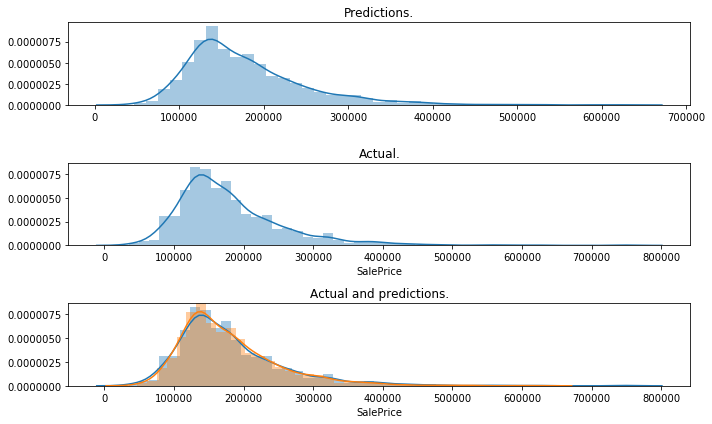

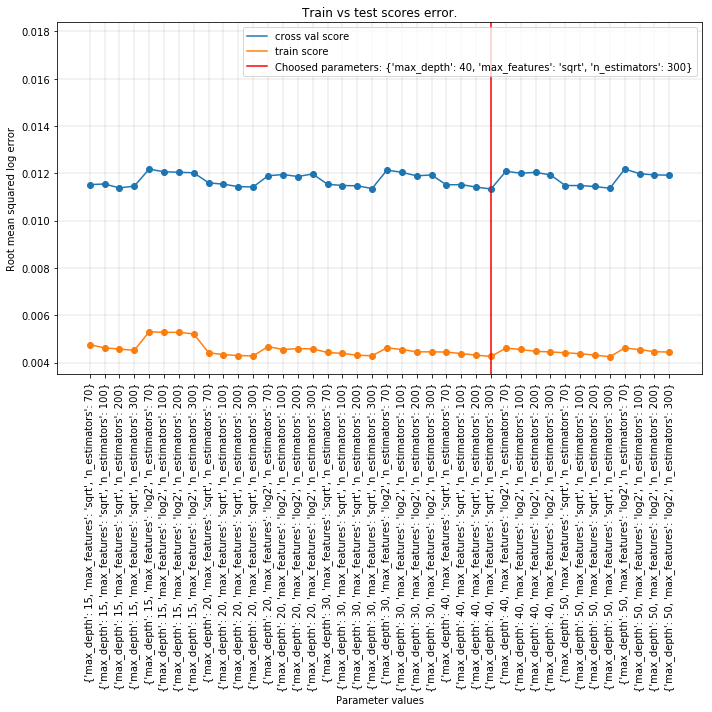

In [3]:
param_grid = {'n_estimators': [70, 100, 200, 300], 'max_depth': [15, 20, 30, 40, 50], 'max_features': ['sqrt', 'log2']}
rf = RandomForestRegressor()
rf_results = predict(TreeResults, rf, param_grid, trainWithDummies,
                        np.log1p(ytrain), testWithDummies, 
                        'first_tree',
                       predictions_form_restoring_method=restore_predictions_from_log1p)

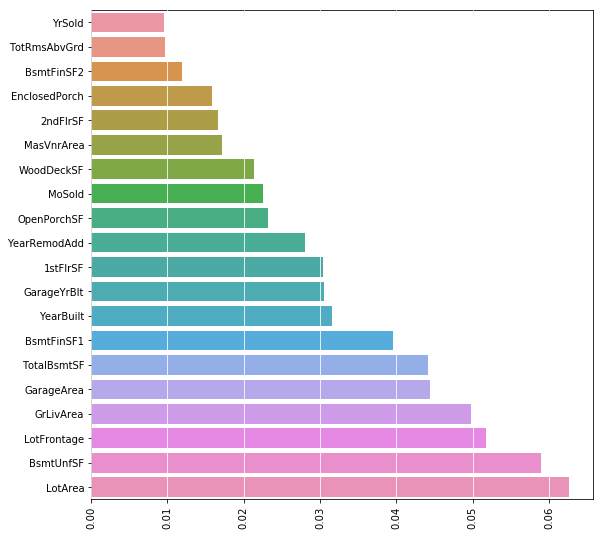

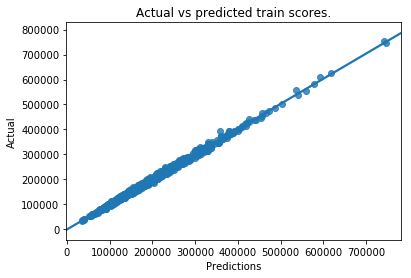

c:\users\matka\anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


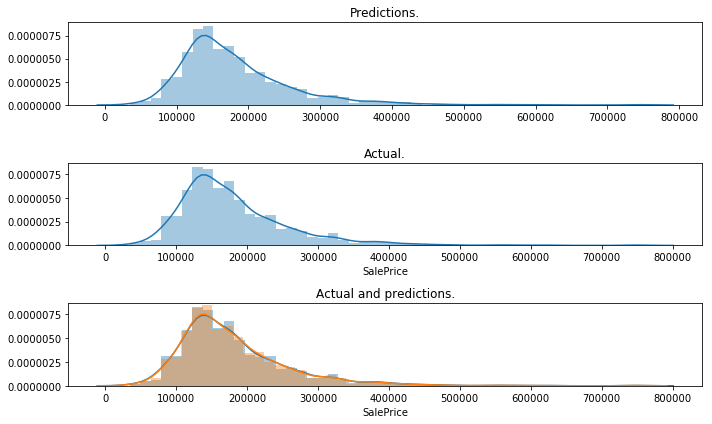

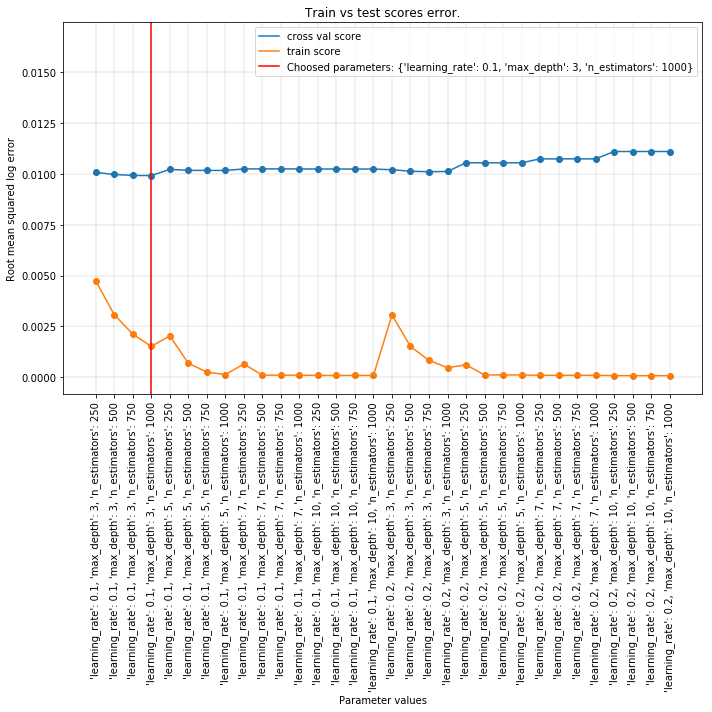

In [192]:
import xgboost as xgb

param_grid = {'learning_rate': [.1, .2,], 'n_estimators': [250, 500, 750, 1000], 'max_depth': [3, 5, 7, 10]}
xgb_model = xgb.XGBRegressor()

xgb_results = predict(TreeResults, xgb_model, param_grid, trainWithDummies,
                        np.log1p(ytrain), testWithDummies, name='xgb',
                       predictions_form_restoring_method=restore_predictions_from_log1p)

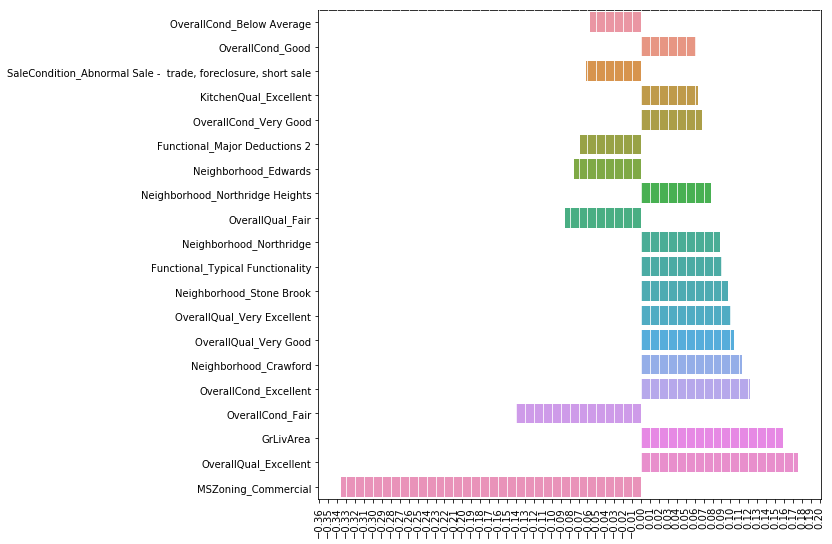

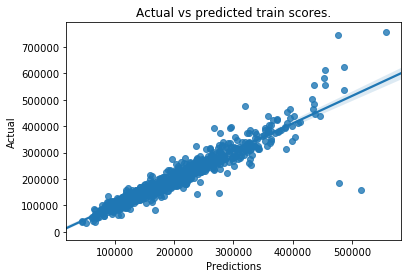

c:\users\matka\anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


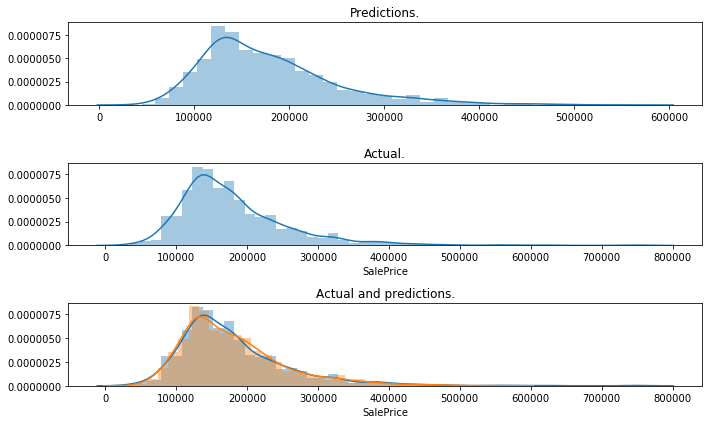

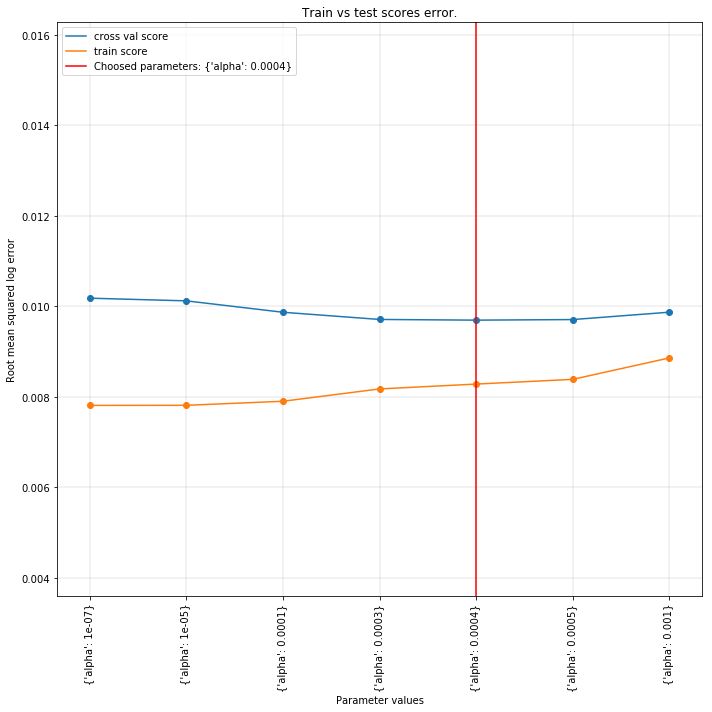

In [5]:
from utils.ClassifierResults import RegressionResults
from sklearn.linear_model import Lasso

alphas = [1e-7, 1e-5, 1e-4, 3e-4, 4e-4, 5e-4, 1e-3]
param_grid = dict(alpha=alphas)

lasso_results = predict(RegressionResults, Lasso(normalize=False, max_iter=5000), param_grid, trainWithDummies,
                        np.log1p(ytrain), testWithDummies, name=None,
                        predictions_form_restoring_method=restore_predictions_from_log1p)

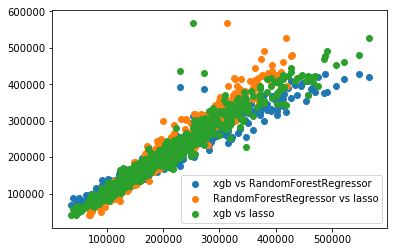

In [8]:
def plot_test_predictions(first, second, label):
    plt.scatter(first, second, label=label)
    
plot_test_predictions(xgb_results.test_predictions, rf_results.test_predictions, label='xgb vs RandomForestRegressor')
plot_test_predictions(rf_results.test_predictions, lasso_results.test_predictions, label='RandomForestRegressor vs lasso')
plot_test_predictions(xgb_results.test_predictions, lasso_results.test_predictions, label='xgb vs lasso')
plt.legend()

In [58]:
def get_predictions(rf_results, xgb_results, lasso_results):
    return .2 * rf_results + .2 * xgb_results + .6 * lasso_results

predictions = get_predictions(rf_results.test_predictions, xgb_results.test_predictions, lasso_results.test_predictions)
predictions.to_csv('scores/ensemble_13186.csv')
predictions.head()

,SalePrice
Id,
1461,121240.490039
1462,151250.828679
1463,188995.256139
1464,195278.171087
1465,197249.370989


# Getting subset of features

In [85]:
lasso_best_cols = lasso_results.get_most_important_columns(50)
rf_best_cols = rf_results.get_most_important_columns(20)
xgb_best_cols = xgb_results.get_most_important_columns(20)
best_cols = lasso_best_cols + rf_best_cols + xgb_best_cols
best_cols = list(set(best_cols))
len(best_cols)

72

In [160]:
df = pd.DataFrame(lasso_results.coefficients, columns=['lasso'])
df['rf'] = rf_results.coefficients
df['xgb'] = xgb_results.coefficients
df = np.abs(df)
df.head()

,lasso,rf,xgb
LotFrontage,0.000000,0.012189,0.051724
LotArea,0.035521,0.021479,0.062696
YearBuilt,0.043033,0.054658,0.031505
YearRemodAdd,0.016567,0.028536,0.028056
MasVnrArea,0.004946,0.010537,0.017085


In [168]:
a = df.sum(axis=1).sort_values(ascending=False).to_frame()
a.columns = ['col_importance']
a.head(10)

,col_importance
MSZoning_Commercial,0.341810
GrLivArea,0.285442
OverallQual_Excellent,0.179643
OverallCond_Fair,0.146132
YearBuilt,0.129195
OverallCond_Excellent,0.126255
LotArea,0.119696
TotalBsmtSF,0.116777
Neighborhood_Crawford,0.116546
OverallQual_Very Good,0.116369


In [163]:
b = pd.DataFrame(df.lasso * df.rf * df.xgb, columns=['col_importance']).sort_values(by='col_importance', ascending=False)
b.head(10)

,col_importance
GrLivArea,0.000607
YearBuilt,0.000074
TotalBsmtSF,0.000049
LotArea,0.000048
BsmtFinSF1,0.000020
YearRemodAdd,0.000013
GarageCars,0.000012
2ndFlrSF,0.000009
1stFlrSF,0.000005
OverallQual_Very Good,0.000003


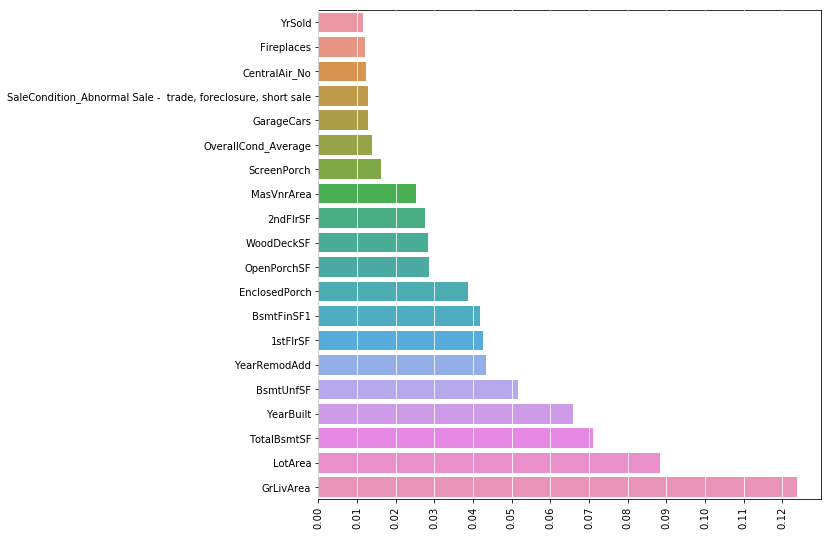

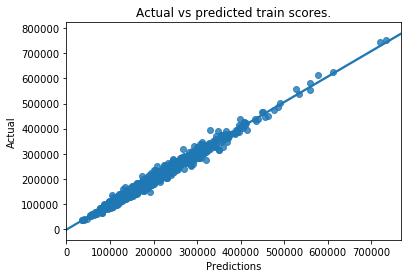

c:\users\matka\anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


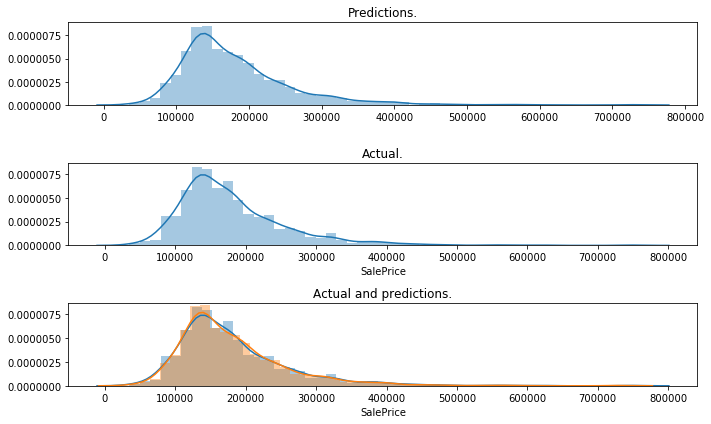

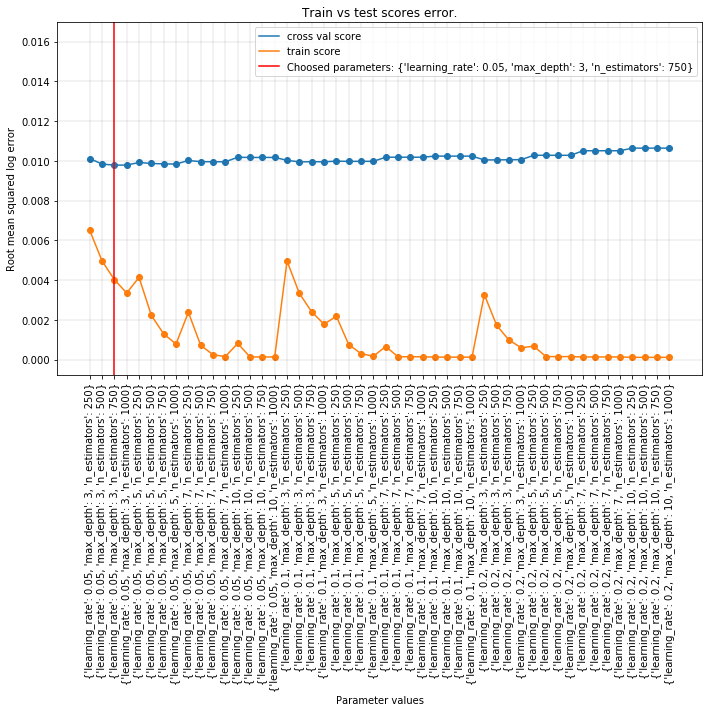

In [197]:
best_cols = b[b.col_importance > b.col_importance.quantile(.75)].index
param_grid = {'learning_rate': [.05, .1, .2,], 'n_estimators': [250, 500, 750, 1000], 'max_depth': [3, 5, 7, 10]}
xgb_model = xgb.XGBRegressor()

xgb_cols_selected = predict(TreeResults, xgb_model, param_grid, trainWithDummies[best_cols],
                        np.log1p(ytrain), testWithDummies[best_cols], name='xgb_cols_selected_cols_multed',
                       predictions_form_restoring_method=restore_predictions_from_log1p)

Isomap(eigen_solver='auto', max_iter=None, n_components=3, n_jobs=-1,
    n_neighbors=5, neighbors_algorithm='auto', path_method='auto', tol=0)

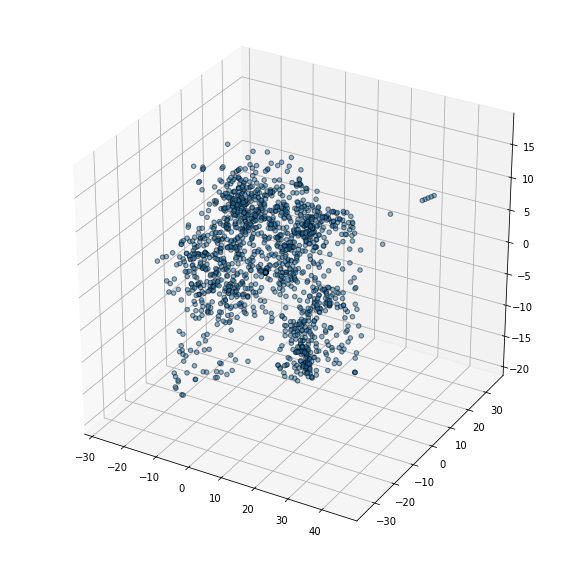

In [93]:
from sklearn.manifold import Isomap
iso = Isomap(n_components=3, n_jobs=-1)
iso.fit(testWithDummies.values)
data_projected = iso.transform(testWithDummies.values)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter3D(data_projected[:, 0], data_projected[:, 1], data_projected[:, 2], edgecolor='none', alpha=0.5)

Isomap(eigen_solver='auto', max_iter=None, n_components=3, n_jobs=-1,
    n_neighbors=5, neighbors_algorithm='auto', path_method='auto', tol=0)

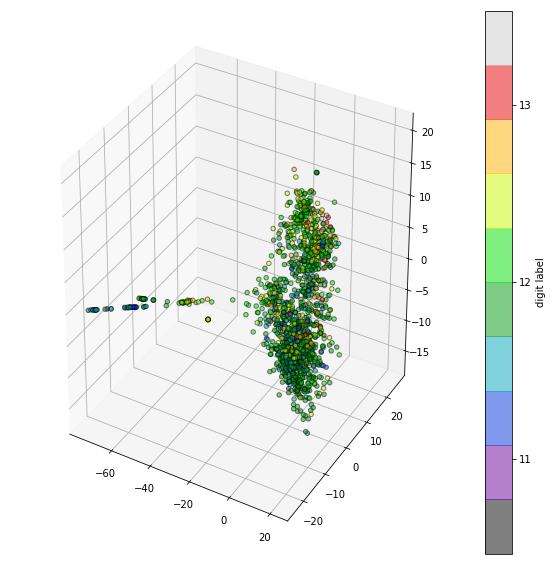

In [88]:
from sklearn.manifold import Isomap
iso = Isomap(n_components=3, n_jobs=-1)
iso.fit(trainWithDummies.values)
data_projected = iso.transform(trainWithDummies.values)

from mpl_toolkits.mplot3d import Axes3D

y = np.log1p(ytrain)

fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter3D(data_projected[:, 0], data_projected[:, 1], data_projected[:, 2],
            c=y.values, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))

fig.colorbar(p, label='digit label', ticks=range(int(y.min()), int(y.max()) + 1),
            cmap=plt.cm.get_cmap('nipy_spectral', 10) )

In [10]:
df = pd.DataFrame(data_projected)
df.head()

,0,1,2
0,2.822213,10.461234,1.918621
1,-9.127374,2.708934,-7.491843
2,2.983306,13.488842,2.189803
3,-7.136257,-8.789216,4.934104
4,5.518726,17.657296,4.154904


In [187]:
def get_outliers(df, upper_quantile=.995, lower_quantile=.005):
    outlier_indexes = []
    for c in df.columns:
        outlier_indexes.append(list(df[df[c] > df[c].quantile(upper_quantile)].index))
        outlier_indexes.append(list(df[df[c] < df[c].quantile(lower_quantile)].index))
    return np.array(outlier_indexes).flatten()

In [188]:
out  = get_outliers(df)
# out.sort()
to_remove = np.unique(out)
to_remove.shape

(40,)

In [189]:
to_remove

array([   8,   11,   39,   48,   52,   63,  102,  112,  203,  249,  291,
        304,  313,  342,  523,  527,  583,  591,  649,  703,  769,  778,
        803,  809,  811,  814,  850,  856,  894,  897,  912, 1011, 1078,
       1090, 1186, 1266, 1283, 1393, 1442, 1450], dtype=int64)

In [190]:
train_wo_outliers = trainWithDummies[~trainWithDummies.index.isin(to_remove)]
ytrain_wo_outliers = ytrain[~ytrain.index.isin(to_remove)]

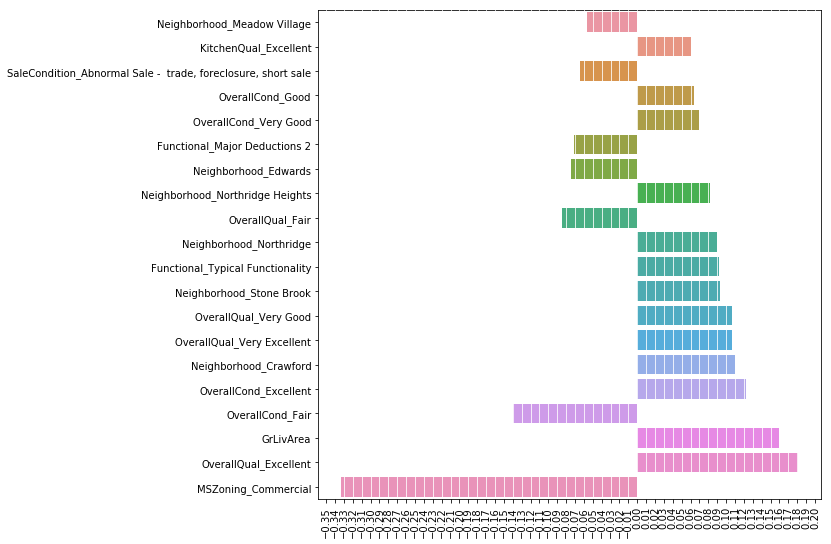

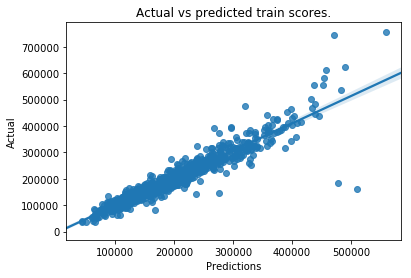

c:\users\matka\anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


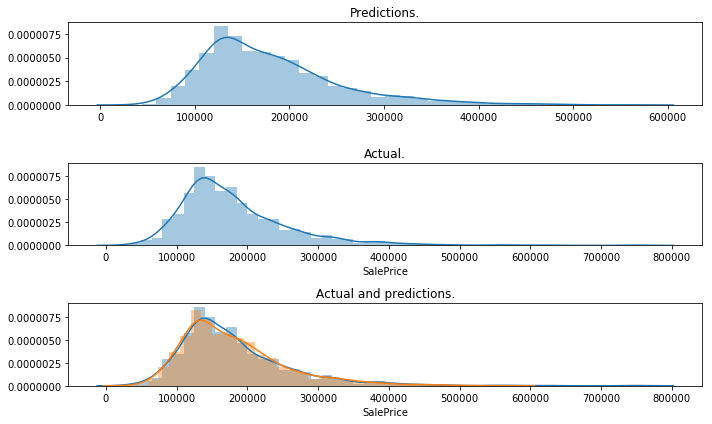

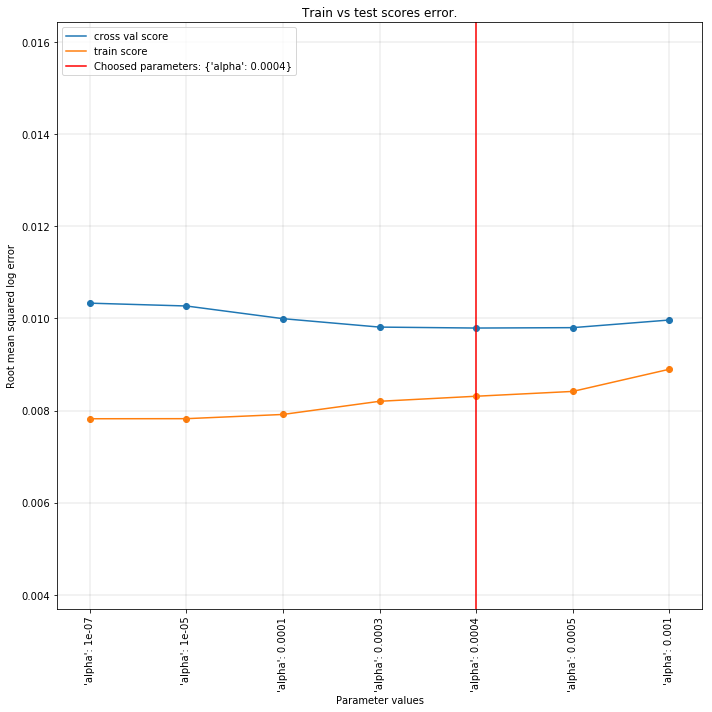

In [191]:
from utils.ClassifierResults import RegressionResults
from sklearn.linear_model import Lasso

alphas = [1e-7, 1e-5, 1e-4, 3e-4, 4e-4, 5e-4, 1e-3]
param_grid = dict(alpha=alphas)

lasso_results = predict(RegressionResults, Lasso(normalize=False, max_iter=5000), param_grid, train_wo_outliers,
                        np.log1p(ytrain_wo_outliers), testWithDummies, name='lasso_removed_outliers',
                        predictions_form_restoring_method=restore_predictions_from_log1p)

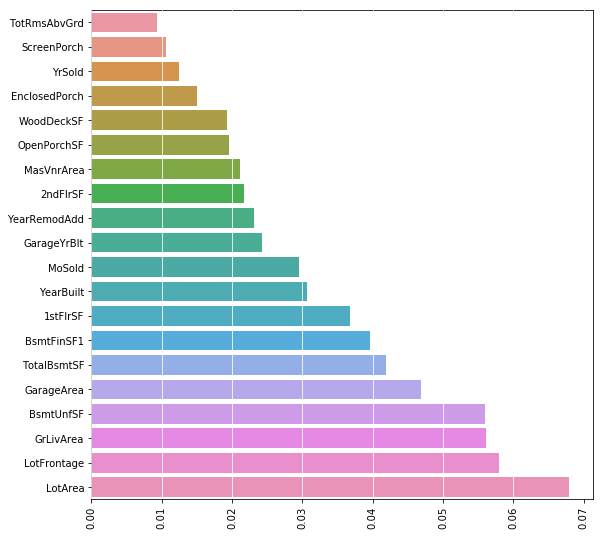

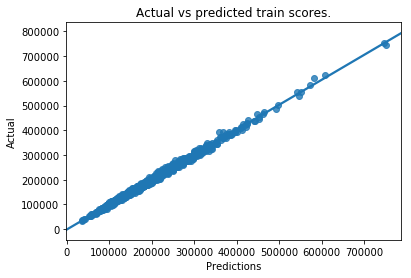

c:\users\matka\anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


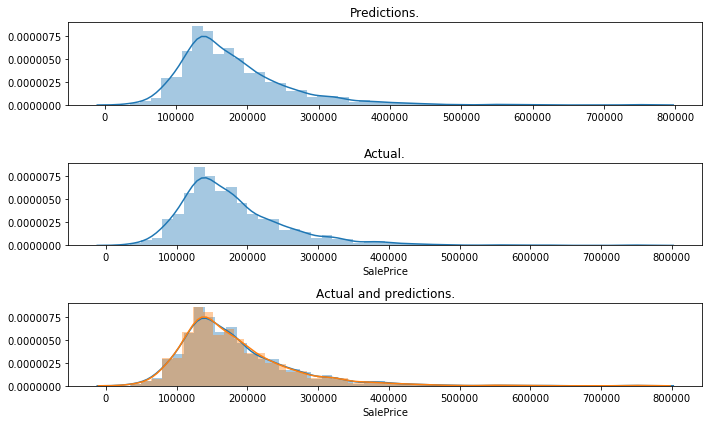

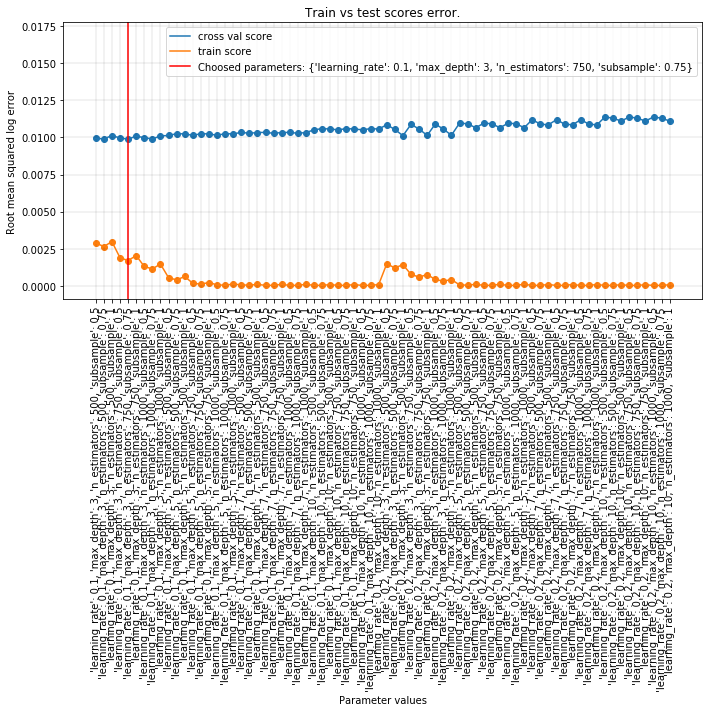

In [201]:
import xgboost as xgb

param_grid = {'learning_rate': [.1, .2,], 'n_estimators': [500, 750, 1000], 'max_depth': [3, 5, 7, 10], 'subsample': [.5, .75, 1]}
xgb_model = xgb.XGBRegressor()

xgb_results = predict(TreeResults, xgb_model, param_grid, train_wo_outliers,
                        np.log1p(ytrain_wo_outliers), testWithDummies, name='xgb',
                       predictions_form_restoring_method=restore_predictions_from_log1p)

In [200]:
def get_predictions(xgb_results, lasso_results):
    return .3 * xgb_results + .7 * lasso_results

predictions = get_predictions(xgb_results.test_predictions, lasso_results.test_predictions)
predictions.to_csv('scores/ensemble-xgb-lasso-wo-outliers.csv')
predictions.head()

,SalePrice
Id,
1461,120012.330884
1462,151392.501591
1463,190903.620260
1464,197009.750543
1465,200415.630305
